<a href="https://colab.research.google.com/github/eliudgarza/eliudgarza/blob/main/Analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Eliud Garza A00827575

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

!pwd

Mounted at /content/gdrive
/content


In [2]:
%cd "/content/gdrive/MyDrive/7mo Semestre/Modulo 2"

!ls

/content/gdrive/MyDrive/7mo Semestre/Modulo 2
 brain_stroke.csv	      'Neural Network.ipynb'   Valhalla23.csv
 mc-donalds-menu.csv	       PlayDataset.csv
'Momento de Retro: Modulo 2'   Titanic


In [197]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as msno 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.preprocessing import LabelEncoder
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn import datasets

In [110]:
def _draw_bootstrap_sample(rng, X, y):
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(
        sample_indices, size=sample_indices.shape[0], replace=True
    )
    return X[bootstrap_indices], y[bootstrap_indices]


def bias_variance_decomp(
    estimator,
    X_train,
    y_train,
    X_test,
    y_test,
    loss="0-1_loss",
    num_rounds=200,
    random_seed=None,
    **fit_params
):
    """
    estimator : object
        A classifier or regressor object or class implementing both a
        `fit` and `predict` method similar to the scikit-learn API.
    X_train : array-like, shape=(num_examples, num_features)
        A training dataset for drawing the bootstrap samples to carry
        out the bias-variance decomposition.
    y_train : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_train` examples.
    X_test : array-like, shape=(num_examples, num_features)
        The test dataset for computing the average loss, bias,
        and variance.
    y_test : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_test` examples.
    loss : str (default='0-1_loss')
        Loss function for performing the bias-variance decomposition.
        Currently allowed values are '0-1_loss' and 'mse'.
    num_rounds : int (default=200)
        Number of bootstrap rounds (sampling from the training set)
        for performing the bias-variance decomposition. Each bootstrap
        sample has the same size as the original training set.
    random_seed : int (default=None)
        Random seed for the bootstrap sampling used for the
        bias-variance decomposition.
    fit_params : additional parameters
        Additional parameters to be passed to the .fit() function of the
        estimator when it is fit to the bootstrap samples.
    Returns
    ----------
    avg_expected_loss, avg_bias, avg_var : returns the average expected
        average bias, and average bias (all floats), where the average
        is computed over the data points in the test set.
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/
    """
    supported = ["0-1_loss", "mse"]
    if loss not in supported:
        raise NotImplementedError("loss must be one of the following: %s" % supported)

    for ary in (X_train, y_train, X_test, y_test):
        if hasattr(ary, "loc"):
            raise ValueError(
                "The bias_variance_decomp does not "
                "support pandas DataFrames yet. "
                "Please check the inputs to "
                "X_train, y_train, X_test, y_test. "
                "If e.g., X_train is a pandas "
                "DataFrame, try passing it as NumPy array via "
                "X_train=X_train.values."
            )

    rng = np.random.RandomState(random_seed)

    if loss == "0-1_loss":
        dtype = np.int64
    elif loss == "mse":
        dtype = np.float64

    all_pred = np.zeros((num_rounds, y_test.shape[0]), dtype=dtype)

    for i in range(num_rounds):
        X_boot, y_boot = _draw_bootstrap_sample(rng, X_train, y_train)

        # Keras support
        if estimator.__class__.__name__ in ["Sequential", "Functional"]:

            # reset model
            for ix, layer in enumerate(estimator.layers):
                if hasattr(estimator.layers[ix], "kernel_initializer") and hasattr(
                    estimator.layers[ix], "bias_initializer"
                ):
                    weight_initializer = estimator.layers[ix].kernel_initializer
                    bias_initializer = estimator.layers[ix].bias_initializer

                    old_weights, old_biases = estimator.layers[ix].get_weights()

                    estimator.layers[ix].set_weights(
                        [
                            weight_initializer(shape=old_weights.shape),
                            bias_initializer(shape=len(old_biases)),
                        ]
                    )

            estimator.fit(X_boot, y_boot, **fit_params)
            pred = estimator.predict(X_test).reshape(1, -1)
        else:
            pred = estimator.fit(X_boot, y_boot, **fit_params).predict(X_test)
        all_pred[i] = pred

    if loss == "0-1_loss":
        main_predictions = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x)), axis=0, arr=all_pred
        )

        avg_expected_loss = np.apply_along_axis(
            lambda x: (x != y_test).mean(), axis=1, arr=all_pred
        ).mean()

        avg_bias = np.sum(main_predictions != y_test) / y_test.size

        var = np.zeros(pred.shape)

        for pred in all_pred:
            var += (pred != main_predictions).astype(np.int)
        var /= num_rounds

        avg_var = var.sum() / y_test.shape[0]

    else:
        avg_expected_loss = np.apply_along_axis(
            lambda x: ((x - y_test) ** 2).mean(), axis=1, arr=all_pred
        ).mean()

        main_predictions = np.mean(all_pred, axis=0)

        avg_bias = np.sum((main_predictions - y_test) ** 2) / y_test.size
        avg_var = np.sum((main_predictions - all_pred) ** 2) / all_pred.size

    return avg_expected_loss, avg_bias, avg_var

In [4]:
dset = pd.read_csv("brain_stroke.csv")

dset.head(5000)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


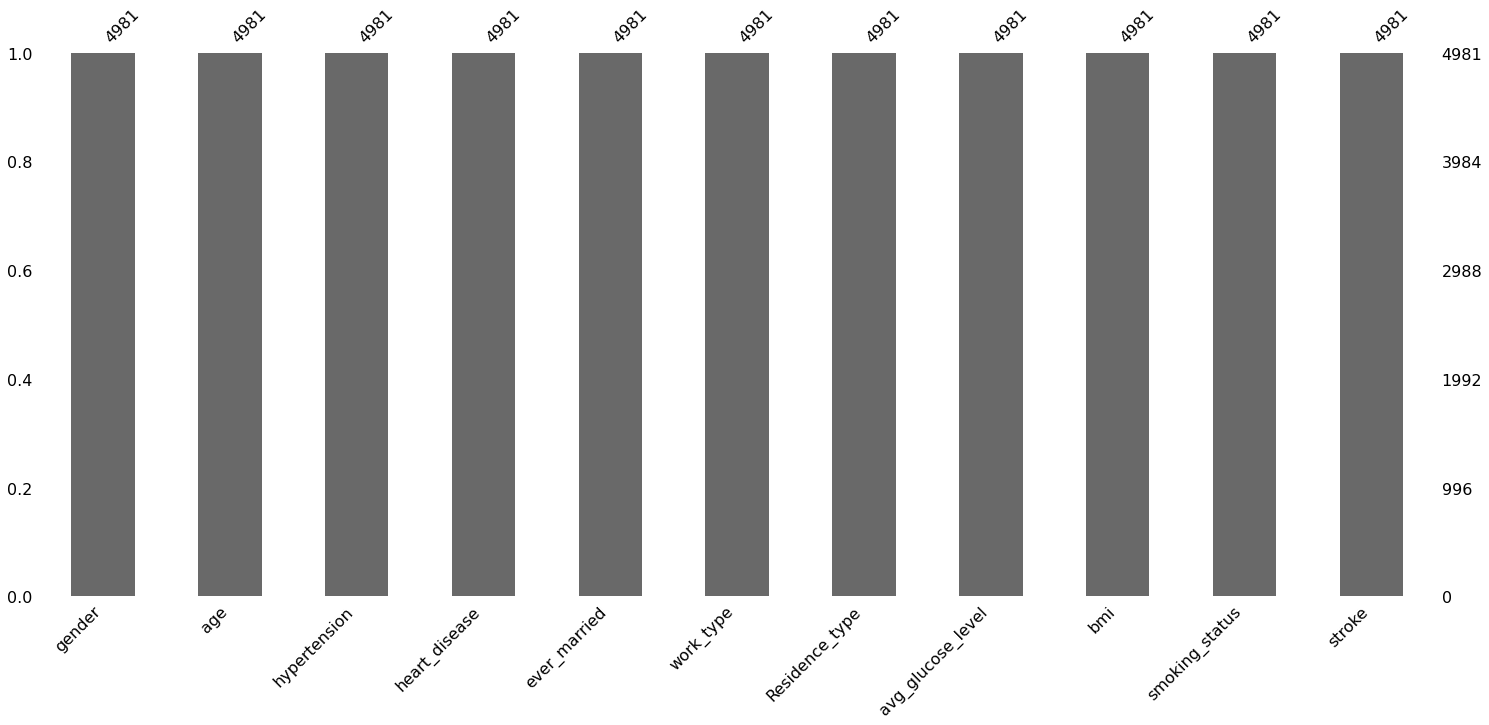

In [5]:
msno.bar(dset)

In [6]:
dset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


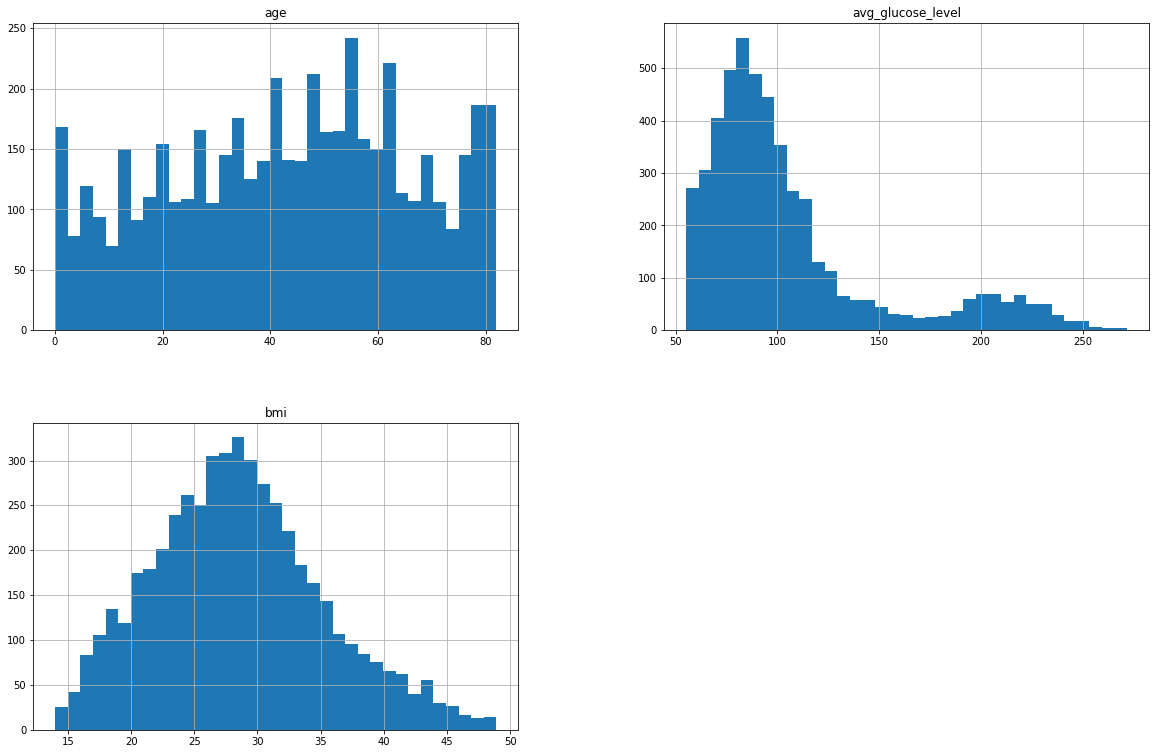

In [80]:
h_dset = dset.drop(["hypertension","heart_disease","gender","ever_married","work_type","Residence_type","stroke","smoking_status"],axis = 1)

h_dset.hist(bins=35, figsize=(20,13))
plt.show()

In [87]:
print(f"Skewness: {dset['age'].skew()}")
print(f"Kurtosis: {dset['age'].kurt()}")

Skewness: -0.14400119564600208
Kurtosis: -0.9948387710574367


In [88]:
print(f"Skewness: {dset['bmi'].skew()}")
print(f"Kurtosis: {dset['bmi'].kurt()}")

Skewness: 0.37155291522876177
Kurtosis: -0.13832077359699424


In [89]:
print(f"Skewness: {dset['avg_glucose_level'].skew()}")
print(f"Kurtosis: {dset['avg_glucose_level'].kurt()}")

Skewness: 1.5875258856135788
Kurtosis: 1.7526730761547773


In [81]:
h_dset.describe()

,age,avg_glucose_level,bmi
count,4981.000000,4981.000000,4981.000000
mean,43.419859,105.943562,28.498173
std,22.662755,45.075373,6.790464
min,0.080000,55.120000,14.000000
25%,25.000000,77.230000,23.700000
50%,45.000000,91.850000,28.100000
75%,61.000000,113.860000,32.600000
max,82.000000,271.740000,48.900000


In [12]:
clean_cat = {"gender": {"Male":0, "Female": 1}, "ever_married": {"No":0,"Yes":1}, "work_type": {"Private":0, "Govt_job":1, "Self-employed":2, "children":3, "Neverworked":4}, "Residence_type": {"Rural":0, "Urban":1}, "smoking_status": {"never smoked":0, "Unknown":1,"formerly smoked":2, "smokes":3}}

dset = dset.replace(clean_cat)

dset.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,1,228.69,36.6,2,1
1,0,80.0,0,1,1,0,0,105.92,32.5,0,1
2,1,49.0,0,0,1,0,1,171.23,34.4,3,1
3,1,79.0,1,0,1,2,0,174.12,24.0,0,1
4,0,81.0,0,0,1,0,1,186.21,29.0,2,1


In [69]:
dset["gender"].value_counts()

1    2907
0    2074
Name: gender, dtype: int64

In [70]:
dset["gender"].value_counts(normalize = True)

1    0.583618
0    0.416382
Name: gender, dtype: float64

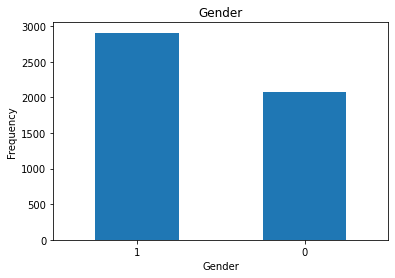

In [62]:

dset["gender"].value_counts().plot(kind="bar")
plt.title("Gender")
plt.xlabel("Values")
plt.xticks(rotation=0)
plt.ylabel("Frequency")
plt.show()

In [60]:
dset["stroke"].value_counts()

0    4733
1     248
Name: stroke, dtype: int64

In [71]:
dset["stroke"].value_counts(normalize = True)

0    0.950211
1    0.049789
Name: stroke, dtype: float64

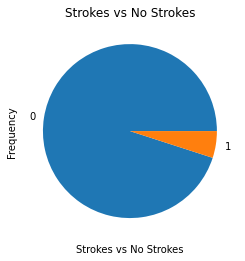

In [66]:

dset["stroke"].value_counts().plot(kind="pie")
plt.title("Strokes vs No Strokes")
plt.xlabel("Values")
plt.xticks(rotation=0)
plt.ylabel("Frequency")
plt.show()

In [52]:
dset["ever_married"].value_counts()

1    3280
0    1701
Name: ever_married, dtype: int64

In [72]:
dset["ever_married"].value_counts(normalize = True)

1    0.658502
0    0.341498
Name: ever_married, dtype: float64

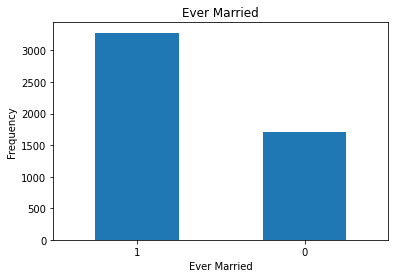

In [63]:
dset["ever_married"].value_counts().plot(kind="bar")
plt.title("Ever Married")
plt.xlabel("Values")
plt.xticks(rotation=0)
plt.ylabel("Frequency")
plt.show()

In [53]:
dset["smoking_status"].value_counts()

0    1838
1    1500
2     867
3     776
Name: smoking_status, dtype: int64

In [73]:
dset["smoking_status"].value_counts(normalize = True)

0    0.369002
1    0.301144
2    0.174061
3    0.155792
Name: smoking_status, dtype: float64

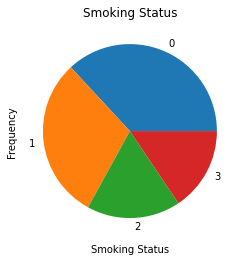

In [67]:
dset["smoking_status"].value_counts().plot(kind="pie")
plt.title("Smoking Status")
plt.xlabel("Values")
plt.xticks(rotation=0)
plt.ylabel("Frequency")
plt.show()

In [54]:
dset["heart_disease"].value_counts()

0    4706
1     275
Name: heart_disease, dtype: int64

In [74]:
dset["heart_disease"].value_counts(normalize = True)

0    0.94479
1    0.05521
Name: heart_disease, dtype: float64

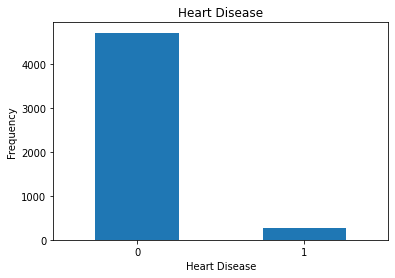

In [65]:
dset["heart_disease"].value_counts().plot(kind="bar")
plt.title("Heart Disease")
plt.xlabel("Values")
plt.xticks(rotation=0)
plt.ylabel("Frequency")
plt.show()

In [13]:
cor = dset.corr()
cor

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,1.000000,0.026538,-0.021485,-0.086476,0.028971,-0.058015,0.004301,-0.055796,0.012093,-0.070968,-0.008870
age,0.026538,1.000000,0.278120,0.264852,0.677137,-0.330243,0.017155,0.236763,0.373703,0.075962,0.246478
hypertension,-0.021485,0.278120,1.000000,0.111974,0.164534,-0.040547,-0.004755,0.170028,0.158762,0.011498,0.131965
heart_disease,-0.086476,0.264852,0.111974,1.000000,0.114765,-0.027299,0.002125,0.166847,0.060926,0.063801,0.134610
ever_married,0.028971,0.677137,0.164534,0.114765,1.000000,-0.336418,0.008191,0.150724,0.371690,0.085733,0.108398
work_type,-0.058015,-0.330243,-0.040547,-0.027299,-0.336418,1.000000,0.008570,-0.052189,-0.360820,-0.043752,-0.035953
Residence_type,0.004301,0.017155,-0.004755,0.002125,0.008191,0.008570,1.000000,0.001346,0.013185,0.036155,0.016494
avg_glucose_level,-0.055796,0.236763,0.170028,0.166847,0.150724,-0.052189,0.001346,1.000000,0.186348,0.024620,0.133227
bmi,0.012093,0.373703,0.158762,0.060926,0.371690,-0.360820,0.013185,0.186348,1.000000,0.061339,0.056926
smoking_status,-0.070968,0.075962,0.011498,0.063801,0.085733,-0.043752,0.036155,0.024620,0.061339,1.000000,0.031013


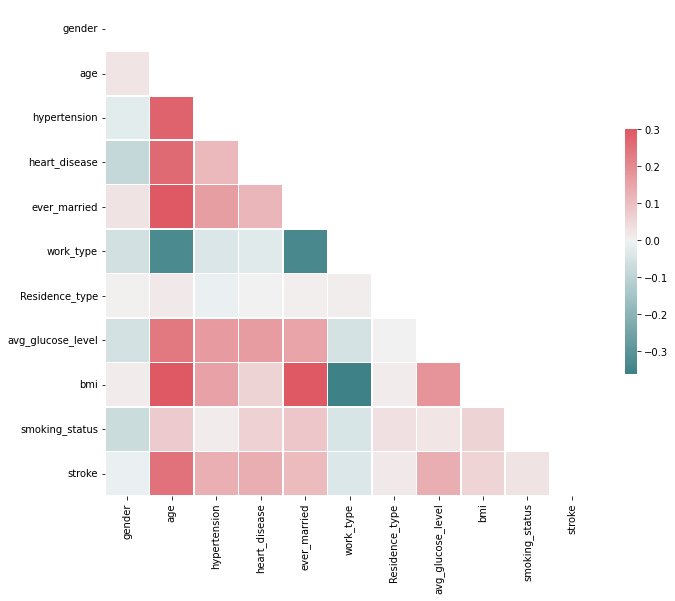

In [14]:


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cor, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [38]:
X = dset.drop(["stroke"], axis = 1)
Y = dset["stroke"]

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [112]:
data = dset.values
X, y = data[:, :-1], data[:, -1]
le=LabelEncoder()
y=le.fit_transform(y)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True,
                                                    stratify=y)

In [194]:
clf_dt = DecisionTreeClassifier(random_state=123)
clf_dt.fit(X_train,y_train)
y_pred=clf_dt.predict(X_test)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf_dt, X_train, y_train, X_test, y_test, 
                                                            loss='0-1_loss',random_seed=123)

print("Accuracy:", accuracy_score(y_test,y_pred))
print("F1 Score:", f1_score(y_test,y_pred))
print("Recall:", recall_score(y_test,y_pred))
print("Precision:",precision_score(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
print('Sklearn 0-1 loss: %.3f' % zero_one_loss(y_test,y_pred))

Accuracy: 0.9117056856187291
F1 Score: 0.17500000000000002
Recall: 0.1891891891891892
Precision: 0.16279069767441862
Confusion Matrix:
 [[1349   72]
 [  60   14]]
Average expected loss: 0.094
Average bias: 0.055
Average variance: 0.060
Sklearn 0-1 loss: 0.088


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [186]:
clf_dt.fit(X_train, y_train)
train_predictions = clf_dt.predict(X_train)
test_predictions = clf_dt.predict(X_test)
train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, test_predictions)
print('train acc', train_acc)
print('test acc', test_acc)

train acc 1.0
test acc 0.9117056856187291


In [187]:
### Después Pruning ###
clf_dt_prnd = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=123)
clf_dt_prnd.fit(X_train,y_train)
y_pred=clf_dt_prnd.predict(X_test)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        clf_dt_prnd, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=123)


print('Average expected loss--After pruning: %.3f' % avg_expected_loss)
print('Average bias--After pruning: %.3f' % avg_bias)
print('Average variance--After pruning: %.3f' % avg_var)
print('Sklearn 0-1 loss--After pruning: %.3f' % zero_one_loss(y_test,y_pred))

Accuracy: 0.9478260869565217
F1 Score: 0.0
Recall: 0.0
Precision: 0.0
Average expected loss--After pruning: 0.053
Average bias--After pruning: 0.049
Average variance--After pruning: 0.005
Sklearn 0-1 loss--After pruning: 0.052


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [188]:
clf_dt_prnd.fit(X_train, y_train)
train_predictions = clf_dt_prnd.predict(X_train)
test_predictions = clf_dt_prnd.predict(X_test)
train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, test_predictions)
print('train acc', train_acc)
print('test acc', test_acc)

train acc 0.9515203671830178
test acc 0.9478260869565217


In [189]:
clf_dt_prnd = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
clf_dt_prnd.fit(X_train,y_train)
y_pred=clf_dt_prnd.predict(X_test)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        clf_dt_prnd, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=123)


print('Average expected loss--After pruning: %.3f' % avg_expected_loss)
print('Average bias--After pruning: %.3f' % avg_bias)
print('Average variance--After pruning: %.3f' % avg_var)
print('Sklearn 0-1 loss--After pruning: %.3f' % zero_one_loss(y_test,y_pred))

Accuracy: 0.9505016722408027
F1 Score: 0.0
Recall: 0.0
Precision: 0.0
Average expected loss--After pruning: 0.051
Average bias--After pruning: 0.049
Average variance--After pruning: 0.002
Sklearn 0-1 loss--After pruning: 0.049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [190]:
clf_dt_prnd.fit(X_train, y_train)
train_predictions = clf_dt_prnd.predict(X_train)
test_predictions = clf_dt_prnd.predict(X_test)
train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, test_predictions)
print('train acc', train_acc)
print('test acc', test_acc)

train acc 0.9500860585197934
test acc 0.9505016722408027


In [191]:

clf_RF = RandomForestClassifier(max_depth=2, random_state=0)
clf_RF.fit(X_train,y_train)
y_pred=clf_RF.predict(X_test)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        clf_RF, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=123)



print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
print('Sklearn 0-1 loss: %.3f' % zero_one_loss(y_test,y_pred))

Accuracy: 0.9505016722408027
F1 Score: 0.0
Recall: 0.0
Precision: 0.0
Average expected loss: 0.049
Average bias: 0.049
Average variance: 0.000
Sklearn 0-1 loss: 0.049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [159]:

clf_RF.fit(X_train, y_train)
train_predictions = clf_RF.predict(X_train)
test_predictions = clf_RF.predict(X_test)
train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, test_predictions)
print('train acc', train_acc)
print('test acc', test_acc)


train acc 0.9500860585197934
test acc 0.9505016722408027


<function matplotlib.pyplot.show(*args, **kw)>

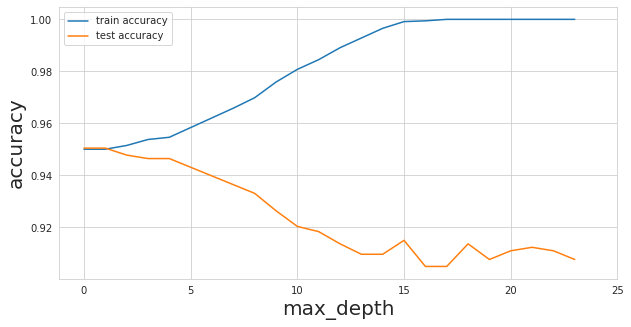

In [203]:
train_accuracies = []
test_accuracies = []

for depth in range(1,25):
  tree_model = DecisionTreeClassifier(max_depth=depth)
  tree_model.fit(X_train, y_train)

  train_predictions = tree_model.predict(X_train)
  test_predictions = tree_model.predict(X_test)

  train_accuracy = metrics.accuracy_score(y_train, train_predictions)
  test_accuracy = metrics.accuracy_score(y_test,test_predictions)

  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)



plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(test_accuracies, label = "test accuracy")
plt.legend(loc = "upper left")
plt.xticks(range(0,26,5))
plt.xlabel("max_depth",size = 20)
plt.ylabel("accuracy",size = 20)
plt.show